# Set Up the Environment

### Importing Libraries

In [1]:
%pip install  pytorch-msssim
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from datasets import load_dataset
import torchvision
from torchvision import transforms
from transformers import AutoModelForDepthEstimation
import time
import timm
import PIL
from PIL import Image
import requests
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
from pytorch_msssim import ssim
from typing import List, Dict, Tuple

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

### Mount Drive

In [2]:
from google.colab import drive

drive.mount('/content/drive')



Mounted at /content/drive


# Define Needed Classes & Functions

### Class for Depth Model

In [3]:
class DepthModel(nn.Module):
    """
    Wrapper class for the Depth-Anything model.
    """
    def __init__(self):
        super().__init__()
        self.model = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf").to(device)
        self.model.eval()

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, List[torch.Tensor]]:
        """
        Runs a forward pass and returns the normalized depth map and features.

        Args:
            x (torch.Tensor): The input image tensor.

        Returns:
            A tuple containing:
            - final_depth (torch.Tensor): The normalized depth map in the range [0, 1].
            - selected_features (List[torch.Tensor]): A list of intermediate feature maps from the encoder.
        """
        original_size = x.shape[2:]

        # The teacher's weights are frozen, so we use no_grad for efficiency
        with torch.no_grad():
            # 1. Get model outputs, including hidden states for feature matching.
            outputs = self.model(x, output_hidden_states=True)

            predicted_depth = outputs.predicted_depth
            hidden_states = outputs.hidden_states

        # 2. Normalize the raw depth map to the range [0, 1].
        if predicted_depth.dim() == 3:
            predicted_depth = predicted_depth.unsqueeze(1)

        b, c, h, w = predicted_depth.shape
        predicted_depth_flat = predicted_depth.view(b, -1)
        max_vals = predicted_depth_flat.max(dim=1, keepdim=True)[0]
        max_vals[max_vals == 0] = 1.0 # Avoid division by zero
        normalized_depth = (predicted_depth_flat / max_vals).view(b, c, h, w)

        # 3. Interpolate the normalized depth map back to the original input image size.
        final_depth = F.interpolate(normalized_depth, size=original_size, mode='bilinear', align_corners=False)

        # 4. Select specific feature maps for distillation. For ViT-based models,
        # [3, 5, 7, 11] correspond to different blocks in DINOv2's encoder.
        selected_features = [hidden_states[i] for i in [3, 5, 7, 11]]

        # 5. *** FIX: Reshape ViT features to be compatible with CNN features ***
        # Convert from [B, SeqLen, C] to [B, C, H, W]
        reshaped_features = []
        patch_size = self.model.config.patch_size # This is typically 14 for DINOv2
        H_grid = x.shape[2] // patch_size
        W_grid = x.shape[3] // patch_size

        for feature_map in selected_features:
            batch_size, seq_len, num_channels = feature_map.shape

            # Remove the [CLS] token (the first element in the sequence)
            image_patch_tokens = feature_map[:, 1:, :]

            # Sanity check
            expected_seq_len = H_grid * W_grid
            if image_patch_tokens.shape[1] != expected_seq_len:
                 raise ValueError(
                    f"After removing [CLS] token, sequence length is {image_patch_tokens.shape[1]}, "
                    f"but expected {expected_seq_len} ({H_grid}x{W_grid}) patches."
                )

            # Reshape the feature map from [B, SeqLen, C] to [B, C, H, W]
            reshaped_map = image_patch_tokens.transpose(1, 2).reshape(batch_size, num_channels, H_grid, W_grid)
            reshaped_features.append(reshaped_map)

        return final_depth, reshaped_features

### Class for Student Model

In [ ]:
# # Create a dummy input tensor
# dummy_input = torch.randn(1, 3, 224, 224)

# # Load the encoder
# encoder = timm.create_model(
#     'mobilevit_xs',
#     pretrained=True,
#     features_only=True
# )

# # Pass the dummy input through the encoder
# feature_maps = encoder(dummy_input)

# # Print the shape of each feature map
# print("Detected Feature Map Shapes (batch_size, channels, height, width):")
# for i, fm in enumerate(feature_maps):
#     print(f"Feature Map {i}: {fm.shape}")

# print("\n----------------------------------")
# print("Correct Channel Sizes to use in Decoder:")
# for i, fm in enumerate(feature_maps):
#     print(f"Skip Connection {i}: {fm.shape[1]} channels")


In [13]:
class UpsampleBlock(nn.Module):
    """
    A simple block that upsamples the feature map and applies a convolution.
    This is used to increase the spatial resolution of the features.
    """
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        # Using a depthwise separable convolution for efficiency
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(self.upsample(x))

In [14]:
class FeatureFusionBlock(nn.Module):
    """
    Fuses features from a higher-level decoder stage with features
    from a lower-level encoder stage (skip connection).
    """
    def __init__(self, channels: int):
        super().__init__()
        # Using a depthwise separable convolution for efficiency
        self.conv = nn.Sequential(
            nn.Conv2d(channels * 2, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
        )

    def forward(self, higher_level_features: torch.Tensor, skip_features: torch.Tensor) -> torch.Tensor:
        # Assumes higher_level_features have already been upsampled to match skip_features' spatial dimensions
        fused_features = torch.cat([higher_level_features, skip_features], dim=1)
        return self.conv(fused_features)

In [15]:
class MiniDPT(nn.Module):
    """
    A lightweight, DPT-like decoder designed for a MobileViT backbone.

    It takes features from three different stages of the encoder and progressively
    fuses them to produce a single-channel depth map.
    """
    def __init__(self, encoder_channels: List[int], decoder_channels: List[int]):
        """
        Args:
            encoder_channels (List[int]): A list of channel counts for the features
                                          extracted from the encoder, from lowest level
                                          to highest level.
                                          e.g., [64, 128, 256]
            decoder_channels (List[int]): A list of channel counts for the decoder stages.
                                          The length should be the same as encoder_channels.
                                          e.g., [32, 64, 128]
        """
        super().__init__()

        if len(encoder_channels) != len(decoder_channels):
            raise ValueError("Encoder and decoder channel lists must have the same length.")

        # Reverse for processing from high-level to low-level
        encoder_channels = encoder_channels[::-1] # Now [256, 128, 64]
        decoder_channels = decoder_channels[::-1] # Now [128, 64, 32]

        # 1. Initial 1x1 convolutions to project encoder features to decoder dimensions
        self.projection_convs = nn.ModuleList()
        for i in range(len(encoder_channels)):
            self.projection_convs.append(nn.Sequential(
                nn.Conv2d(encoder_channels[i], decoder_channels[i], kernel_size=1, bias=False),
                nn.BatchNorm2d(decoder_channels[i]),
                nn.ReLU(inplace=True),
            ))

        # 2. Upsampling and Fusion blocks
        self.upsample_blocks = nn.ModuleList()
        self.fusion_blocks = nn.ModuleList()

        for i in range(len(decoder_channels) - 1):
            # Upsample from the current decoder channel count to the next (lower) one
            self.upsample_blocks.append(UpsampleBlock(decoder_channels[i], decoder_channels[i+1]))
            # Fusion block takes the upsampled features and the projected skip connection
            self.fusion_blocks.append(FeatureFusionBlock(decoder_channels[i+1]))

        # 3. Final prediction head to produce the single-channel depth map
        self.prediction_head = nn.Sequential(
            nn.Conv2d(decoder_channels[-1], decoder_channels[-1] // 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(decoder_channels[-1] // 2, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, kernel_size=1),
            nn.Sigmoid()
        )


    def forward(self, encoder_features: List[torch.Tensor]) -> torch.Tensor:
        """
        Args:
            encoder_features (List[torch.Tensor]): List of feature maps from the encoder,
                                                   ordered from low-level to high-level.

        Returns:
            torch.Tensor: The final depth map.
        """
        # Reverse the features to process from high-level to low-level
        features = encoder_features[::-1]

        # Project all feature levels to the decoder's channel dimensions
        projected_features = [self.projection_convs[i](features[i]) for i in range(len(features))]

        # Start with the highest-level feature map
        current_features = projected_features[0]

        # Iteratively upsample and fuse with lower-level skip connections
        for i in range(len(self.fusion_blocks)):
            upsampled = self.upsample_blocks[i](current_features)
            skip_connection = projected_features[i+1]
            current_features = self.fusion_blocks[i](upsampled, skip_connection)

        # Generate final prediction
        return self.prediction_head(current_features)


In [ ]:
class StudentDepthModel(nn.Module):
    """
    Combines a MobileViT encoder with the MiniDPT decoder to form a
    complete, end-to-end model for depth estimation.
    """
    def __init__(self, encoder_name='mobilevit_xs', pretrained=True):
        super().__init__()
        # 1. Instantiate the encoder
        self.encoder = timm.create_model(
            encoder_name,
            pretrained=pretrained,
            features_only=True, # This returns a list of feature maps
        )

        self.feature_indices = [0, 1, 2, 3]

        # 2. Get the channel counts from the encoder
        dummy_input = torch.randn(1, 3, 224, 224)
        features = self.encoder(dummy_input)
        # encoder_channels = [f.shape[1] for f in features]
        encoder_channels = [features[i].shape[1] for i in self.feature_indices]

        # 3. Define the decoder channel counts
        # This can be tuned to balance performance and model size.
        decoder_channels = [ 64, 128, 160, 256]

        # Ensure decoder channels list is the same length as encoder channels
        if len(decoder_channels) > len(encoder_channels):
             decoder_channels = decoder_channels[:len(encoder_channels)]
        elif len(decoder_channels) < len(encoder_channels):
             # You might want to handle this differently, e.g., by padding
             raise ValueError("Decoder channels list is shorter than encoder channels list.")


        # 4. Instantiate the decoder
        self.decoder = MiniDPT(encoder_channels, decoder_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns:
            A tuple containing:
            - The final depth map (torch.Tensor).
            - A list of intermediate feature maps from the encoder (List[torch.Tensor]).
        """
        features = self.encoder(x)
        selected_features = [features[i] for i in self.feature_indices]
        depth_map = self.decoder(selected_features)
        return depth_map, selected_features


In [ ]:
# 1. Instantiate the complete student model
print("Instantiating the Student Depth Model (MobileViT-XS + MiniDPT)...")
model = StudentDepthModel(encoder_name='mobilevit_xs', pretrained=True)
model.eval()

# 2. Create a dummy input tensor
input_size = 224
dummy_input = torch.randn(1, 3, input_size, input_size)
print(f"\nInput image shape: {dummy_input.shape}")

# 3. Run the forward pass
with torch.no_grad():
  depth_map, Sfeat = model(dummy_input)

# 4. Print the output shape and parameter count
# The output should be full resolution [B, 1, H, W]
print(f"Final depth map shape: {depth_map.shape}")

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters in Student Model: {total_params / 1e6:.2f}M")

Instantiating the Student Depth Model (MobileViT-XS + MiniDPT)...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/9.34M [00:00<?, ?B/s]


Input image shape: torch.Size([1, 3, 224, 224])
Final depth map shape: torch.Size([1, 1, 224, 224])

Total parameters in Student Model: 4.29M


### Class for Dataset Loading & Preprocessing

In [10]:
class UnlabeledImageDataset(Dataset):
    """
    Custom dataset for unlabeled images.
    """
    def __init__(self, root_dir, transform=None, resize_size=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('png', 'jpg', 'JPG'))]
        self.resize_size = resize_size
        print(f"Found {len(self.image_paths)} images in {root_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.resize_size:
            image = image.resize(self.resize_size)

        if self.transform:
            image = self.transform(image)


        return image

### Distillation Loss

In [8]:
def compute_depth_gradients(depth_map: torch.Tensor) -> torch.Tensor:
    """
    Computes image gradients (dy, dx) for a batch of depth maps.
    """
    # Create Sobel filters for GPU computation
    sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32, device=depth_map.device).view(1, 1, 3, 3)
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32, device=depth_map.device).view(1, 1, 3, 3)

    # Apply filters using depthwise convolution
    grad_y = F.conv2d(depth_map, sobel_y, padding=1)
    grad_x = F.conv2d(depth_map, sobel_x, padding=1)

    # Return stacked gradients
    return torch.cat([grad_y.abs(), grad_x.abs()], dim=1)


In [9]:
class DistillationLoss(nn.Module):
    """
    An enhanced loss function for knowledge distillation in depth estimation.

    Combines four components:
    1. Scale-Invariant Log (SILog) Loss: For overall depth accuracy.
    2. Gradient Matching Loss (L1): For preserving edges and fine details.
    3. Feature Matching Loss (L1): To mimic the teacher's feature representations.
    4. Attention Matching Loss (L2): To encourage the student to focus on the same
       spatial regions as the teacher.
    """
    def __init__(self, lambda_silog: float = 1.0, lambda_grad: float = 0.2, lambda_feat: float = 0.1, lambda_attn: float = 1.0, alpha: float = 0.5):
        """
        Args:
            lambda_silog (float): Weight for the SILog depth loss.
            lambda_grad (float): Weight for the gradient matching loss.
            lambda_feat (float): Weight for the feature-matching loss.
            lambda_attn (float): Weight for the attention-matching loss.
            alpha (float): Parameter for the SILog loss.
        """
        super().__init__()
        self.lambda_silog = lambda_silog
        self.lambda_grad = lambda_grad
        self.lambda_feat = lambda_feat
        self.lambda_attn = lambda_attn
        self.alpha = alpha

        self.l1_loss = nn.L1Loss()
        self.l2_loss = nn.MSELoss() # L2 is often used for attention maps

        self.projection_convs = None # Will be initialized on the first forward pass

    def _initialize_projections(self, student_features: List[torch.Tensor], teacher_features: List[torch.Tensor], device: torch.device):
        """Dynamically creates projection layers to match student and teacher channel counts."""
        self.projection_convs = nn.ModuleList()
        for s_feat, t_feat in zip(student_features, teacher_features):
            s_chan, t_chan = s_feat.shape[1], t_feat.shape[1]
            # Create a 1x1 convolution to project student channels to teacher channels
            proj = nn.Conv2d(s_chan, t_chan, kernel_size=1, bias=False).to(device)
            self.projection_convs.append(proj)
        print("Initialized projection layers for feature matching.")

    def _compute_attention_map(self, feature_map: torch.Tensor) -> torch.Tensor:
        """Computes a spatial attention map from a feature map."""
        # Summarize across the channel dimension by taking the mean absolute value
        return torch.mean(torch.abs(feature_map), dim=1, keepdim=True)


    def forward(
        self,
        student_depth: torch.Tensor,
        teacher_depth: torch.Tensor,
        student_features: List[torch.Tensor],
        teacher_features: List[torch.Tensor],
    ) -> torch.Tensor:
        """Calculates the combined distillation loss."""
        device = student_depth.device

        # Initialize projection layers on the first pass
        if self.projection_convs is None:
            self._initialize_projections(student_features, teacher_features, device)

        # --- 1. SILog Depth Loss ---
        valid_mask = (student_depth > 1e-8) & (teacher_depth > 1e-8)
        log_diff = torch.log(student_depth[valid_mask]) - torch.log(teacher_depth[valid_mask])
        num_pixels = log_diff.numel()
        silog_loss = torch.sum(log_diff ** 2) / num_pixels - self.alpha * (torch.sum(log_diff) ** 2) / (num_pixels ** 2) if num_pixels > 0 else torch.tensor(0.0, device=device)

        # --- 2. Gradient Matching Loss ---
        student_grads = compute_depth_gradients(student_depth)
        teacher_grads = compute_depth_gradients(teacher_depth)
        grad_loss = self.l1_loss(student_grads, teacher_grads)

        # --- 3. Feature & Attention Matching Loss ---
        feature_loss = torch.tensor(0.0, device=device)
        attention_loss = torch.tensor(0.0, device=device)

        for i, (s_feat, t_feat) in enumerate(zip(student_features, teacher_features)):
            # Project the student feature to match the teacher's channel dimension
            s_feat_projected = self.projection_convs[i](s_feat)

            # Interpolate if spatial sizes don't match (essential for ViT vs CNN features)
            if s_feat_projected.shape[2:] != t_feat.shape[2:]:
                s_feat_resized = F.interpolate(s_feat_projected, size=t_feat.shape[2:], mode='bilinear', align_corners=False)
            else:
                s_feat_resized = s_feat_projected

            # Calculate the L1 feature loss
            feature_loss += self.l1_loss(s_feat_resized, t_feat)

            # Calculate the attention map loss
            s_attn = self._compute_attention_map(s_feat_resized)
            t_attn = self._compute_attention_map(t_feat)
            attention_loss += self.l2_loss(s_attn, t_attn)

        # --- 4. Combine All Losses ---
        total_loss = (self.lambda_silog * silog_loss) + \
                     (self.lambda_grad * grad_loss) + \
                     (self.lambda_feat * feature_loss) + \
                     (self.lambda_attn * attention_loss)

        # You can add a print statement here for debugging the contribution of each loss
        # print(f"Losses -> SILog: {silog_loss.item():.4f}, Grad: {grad_loss.item():.4f}, Feat: {feature_loss.item():.4f}, Attn: {attention_loss.item():.4f}")

        return total_loss

In [ ]:
class DistillationLoss(nn.Module):
    """
    A loss function for knowledge distillation in depth estimation.

    This loss combines two main components:
    1. A scale-invariant log (SILog) loss to compare the final depth predictions
       of the student and teacher.
    2. A feature-matching loss (L1) to encourage the student's intermediate
       feature representations to mimic the teacher's.
    """
    def __init__(self, lambda_depth: float = 1.0, lambda_feature: float = 0.1, alpha: float = 0.5):
        """
        Args:
            lambda_depth (float): Weight for the depth (SILog) loss component.
            lambda_feature (float): Weight for the feature-matching loss component.
            alpha (float): A parameter for the SILog loss, typically 0.5.
        """
        super().__init__()
        self.lambda_depth = lambda_depth
        self.lambda_feature = lambda_feature
        self.alpha = alpha
        self.feature_loss_fn = nn.L1Loss()

        # Define the channel counts for student and teacher features
        # Student (mobilevit_xs): Features from indices 0, 1, 2, 3
        student_channels = [32, 48, 64, 80]
        # Teacher (Depth-Anything-V2-Small): Features from indices 3, 5, 7, 11
        teacher_channels = [384, 384, 384, 384]

        # Create projection layers to match student channels to teacher channels
        self.projection_convs = nn.ModuleList()
        for s_chan, t_chan in zip(student_channels, teacher_channels):
            self.projection_convs.append(
                nn.Conv2d(s_chan, t_chan, kernel_size=1, bias=False)
            )

    def forward(
        self,
        student_depth: torch.Tensor,
        teacher_depth: torch.Tensor,
        student_features: List[torch.Tensor],
        teacher_features: List[torch.Tensor],
    ) -> torch.Tensor:
        """
        Calculates the combined distillation loss.

        Args:
            student_depth (torch.Tensor): The depth map predicted by the student model.
            teacher_depth (torch.Tensor): The pseudo-ground-truth depth map from the teacher.
            student_features (List[torch.Tensor]): Intermediate features from the student's encoder.
            teacher_features (List[torch.Tensor]): Intermediate features from the teacher's encoder.

        Returns:
            torch.Tensor: The final computed loss value.
        """

        # --- 1. SILog Depth Loss ---
        # Create a mask to handle invalid (zero or negative) depth values to avoid log(0).
        # Your teacher wrapper already normalizes to [0, 1], but this is good practice.
        valid_mask = (student_depth > 1e-8) & (teacher_depth > 1e-8)

        # Calculate the log difference
        log_diff = torch.log(student_depth[valid_mask]) - torch.log(teacher_depth[valid_mask])

        # Calculate the SILog loss
        num_pixels = log_diff.numel()
        if num_pixels == 0:
            # Avoid errors if the mask is all False
            depth_loss = torch.tensor(0.0, device=student_depth.device)
        else:
            term1 = torch.sum(log_diff ** 2) / num_pixels
            term2 = (torch.sum(log_diff) ** 2) / (num_pixels ** 2)
            depth_loss = term1 - self.alpha * term2

        # --- 2. Feature Matching Loss ---
        feature_loss = torch.tensor(0.0, device=student_depth.device)
        if self.lambda_feature > 0 and len(student_features) > 0:
            # Ensure the number of feature maps match
            if len(student_features) != len(teacher_features):
                raise ValueError(
                    f"Student and Teacher feature map counts do not match: "
                    f"{len(student_features)} vs {len(teacher_features)}"
                )

            # Sum the L1 loss for each corresponding feature map
            for i, (s_feat, t_feat) in enumerate(zip(student_features, teacher_features)):
                # Project the student feature to match the teacher's channel dimension
                s_feat_projected = self.projection_convs[i](s_feat)

                # Interpolate the projected student features if their spatial size doesn't match
                if s_feat_projected.shape != t_feat.shape:
                    s_feat_resized = F.interpolate(s_feat_projected, size=t_feat.shape[2:], mode='bilinear', align_corners=False)
                else:
                    s_feat_resized = s_feat_projected

                feature_loss += self.feature_loss_fn(s_feat_resized, t_feat)

        # --- 3. Combine Losses ---
        total_loss = (self.lambda_depth * depth_loss) + (self.lambda_feature * feature_loss)

        return total_loss


### The Training Function

In [17]:
def train_knowledge_distillation(teacher, student, train_dataloader, val_dataloader, criterion, optimizer, epochs, device):
    """
    Train the student model using Response-Based knowledge distillation.
    """
    teacher.eval() # Teacher should always be in evaluation mode

    print(f"Starting Knowledge Distillation Training on {device}...")
    min_loss = float('inf')
    for epoch in range(epochs):
        student.train() # Student in training mode
        running_loss = 0.0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        start_time = time.time()

        for images in progress_bar:
            images = images.to(device)
            optimizer.zero_grad()

            # Forward pass with Teacher model (no_grad as teacher is fixed)
            with torch.no_grad():
                teacher_depth, teacher_features = teacher(images) # Returns depth map

            # Forward pass with Student model
            student_depth, student_features  = student(images) # Returns depth map

            # Calculate distillation loss
            loss = criterion(student_depth, teacher_depth, student_features, teacher_features)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()


        epoch_loss = running_loss / len(train_dataloader)
        current_lr = scheduler.get_last_lr()[0]
        end_time = time.time()
        print(f"End of Epoch {epoch+1},Time: {end_time - start_time:.2f}s, Current LR: {current_lr:.6f}, Average Loss: {epoch_loss:.4f}")
        scheduler.step()

        # Validation loop
        student.eval() # Student in evaluation mode for validation
        val_running_loss = 0.0
        with torch.no_grad():
            progress_bar_val = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")
            for val_images in progress_bar_val:
                val_images = val_images.to(device)
                teacher_depth, TFeat = teacher(val_images)
                student_depth, SFeat = student(val_images)
                val_loss = criterion(student_depth, teacher_depth, SFeat, TFeat)
                val_running_loss += val_loss.item()

        val_epoch_loss = val_running_loss / len(val_dataloader)
        print(f"Average Validation Loss: {val_epoch_loss:.4f}")

        if val_epoch_loss < min_loss:
            min_loss = val_epoch_loss
            print("Validation loss improved. Saving the model.")
            torch.save(student.state_dict(), f"/content/drive/MyDrive/CompatibleBestModel.pth")

    print("Knowledge Distillation Training Finished!")

# Training Process

### Define Parameters & Models

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load teacher model


teacher_model = DepthModel().to(device)

# student  model architecture
student_model = StudentDepthModel(encoder_name='mobilevit_xs', pretrained=True).to(device)

######################################################
# Load the entire model object from the checkpoint
# student_model = torch.load('/content/drive/MyDrive/Name.pth', weights_only=False).to(device)
###########################
# Initialize optimizer for the student model
# student_optimizer = optim.Adam(student_model.parameters(), lr=1e-4)

# In your training setup cell

# Get parameters for the encoder and decoder
encoder_params = student_model.encoder.parameters()
decoder_params = student_model.decoder.parameters()

# Setup the optimizer with different learning rates
student_optimizer = optim.AdamW([
    {'params': encoder_params, 'lr': 1e-5},  # A lower learning rate for the encoder
    {'params': decoder_params, 'lr': 1e-4}   # A higher learning rate for the decoder
], weight_decay=1e-3)

# The scheduler will now manage both learning rates
num_epochs = 60
scheduler = CosineAnnealingLR(student_optimizer, T_max=num_epochs, eta_min=1e-6)

# Distillation Loss
# distillation_criterion = DistillationLoss().to(device)
distillation_criterion = DistillationLoss(lambda_silog = 1.0, lambda_grad = 0.2, lambda_feat = 0.1, lambda_attn = 1.0, alpha = 0.5).to(device)
# transformations for input images (teacher and student will use the same)

input_size = (384, 384)

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Specify the path to your unlabeled data in Google Drive
unlabeled_data_path = '/content/drive/MyDrive/images/'

# Create two separate datasets with their respective transforms
train_full_dataset = UnlabeledImageDataset(root_dir=unlabeled_data_path, transform=transform, resize_size=input_size)
val_full_dataset = UnlabeledImageDataset(root_dir=unlabeled_data_path, transform=eval_transform, resize_size=input_size)

# Use the same indices to split both datasets
dataset_size = len(train_full_dataset)
train_size = int(0.7 * dataset_size)
val_size = dataset_size - train_size

indices = list(range(dataset_size))
np.random.shuffle(indices) # a random seed might be useful here: np.random.seed(42)
train_indices, val_indices = indices[:train_size], indices[train_size:]

# Create subsets for training and validation
train_dataset = torch.utils.data.Subset(train_full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(val_full_dataset, val_indices)


# Create separate dataloaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=2)#, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)#, collate_fn=custom_collate_fn)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Using device: cuda
Found 152 images in /content/drive/MyDrive/images/
Found 152 images in /content/drive/MyDrive/images/
Training set size: 106
Validation set size: 46


Before Training

In [21]:
# Load train image
image_path = "/content/drive/MyDrive/images/image1.JPG"
train_image = cv2.imread(image_path)
train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)  # Convert to RGB

train_input_tensor = eval_transform(Image.fromarray(train_image)).unsqueeze(0).to(device)
# Load image
image_path = "/content/test.jpg"
# image_path = "/content/drive/MyDrive/images/image1.JPG"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = eval_transform(Image.fromarray(image)).unsqueeze(0).to(device)

student_model.eval() # Use the DepthModel instance


with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    student_depth_before, Sfeat = student_model(input_tensor)
    student_depth_before_training = student_depth_before.squeeze().cpu().numpy()
    student_depth_before, Sfeat = student_model(train_input_tensor)
    student_depth_before_training_train_image = student_depth_before.squeeze().cpu().numpy()


### Freeze Student's Encoder

In [23]:
# --- Verify which layers are trainable ---
total_param = 0
train_param = 0
for name, param in student_model.named_parameters():
    total_param += param.numel()
    if param.requires_grad:
        train_param += param.numel()
print(f"Total Parameters: {total_param}")
print(f"Trainable Parameters: {train_param}")

print(student_model)
# print("----------------------------------------")
# for name, param in student_model.named_parameters():
#     param.requires_grad = False

# # Unfreeze parameters in the 'head' layer
# for name, param in student_model.decoder.named_parameters():
#     param.requires_grad = True

# # --- Verify which layers are trainable ---
# print("Trainable parameters in student_model:")
# for name, param in student_model.named_parameters():
#     if param.requires_grad:
#         print(f"  {name}")


Total Parameters: 4289105
Trainable Parameters: 4289105
StudentDepthModel(
  (encoder): FeatureListNet(
    (stem): ConvNormAct(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
    )
    (stages_0): Sequential(
      (0): BottleneckBlock(
        (conv1_1x1): ConvNormAct(
          (conv): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
        )
        (conv2_kxk): ConvNormAct(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (bn): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, tra

### Run the Training

In [24]:
    # Run the training
train_knowledge_distillation(
    teacher=teacher_model,
    student=student_model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=distillation_criterion,
    optimizer=student_optimizer,
    epochs=num_epochs,
    device=device
)

print("Training complete. Student model saved at specified checkpoints.")

Starting Knowledge Distillation Training on cuda...


Epoch 1/60:   0%|          | 0/11 [00:00<?, ?it/s]

Initialized projection layers for feature matching.


Epoch 1/60: 100%|██████████| 11/11 [00:43<00:00,  3.93s/it]


End of Epoch 1,Time: 43.23s, Current LR: 0.000010, Average Loss: 1.9210


Epoch 1/60 [Validation]: 100%|██████████| 12/12 [00:23<00:00,  2.00s/it]


Average Validation Loss: 2.3857
Validation loss improved. Saving the model.


Epoch 2/60: 100%|██████████| 11/11 [00:31<00:00,  2.84s/it]


End of Epoch 2,Time: 31.27s, Current LR: 0.000010, Average Loss: 1.6327


Epoch 2/60 [Validation]: 100%|██████████| 12/12 [00:17<00:00,  1.43s/it]


Average Validation Loss: 1.9048
Validation loss improved. Saving the model.


Epoch 3/60: 100%|██████████| 11/11 [00:32<00:00,  2.92s/it]


End of Epoch 3,Time: 32.13s, Current LR: 0.000010, Average Loss: 1.1677


Epoch 3/60 [Validation]: 100%|██████████| 12/12 [00:16<00:00,  1.41s/it]


Average Validation Loss: 1.6538
Validation loss improved. Saving the model.


Epoch 4/60: 100%|██████████| 11/11 [00:30<00:00,  2.77s/it]


End of Epoch 4,Time: 30.51s, Current LR: 0.000010, Average Loss: 1.0511


Epoch 4/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.21s/it]


Average Validation Loss: 1.5424
Validation loss improved. Saving the model.


Epoch 5/60: 100%|██████████| 11/11 [00:31<00:00,  2.90s/it]


End of Epoch 5,Time: 31.88s, Current LR: 0.000010, Average Loss: 1.0208


Epoch 5/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.22s/it]


Average Validation Loss: 1.2837
Validation loss improved. Saving the model.


Epoch 6/60: 100%|██████████| 11/11 [00:31<00:00,  2.87s/it]


End of Epoch 6,Time: 31.60s, Current LR: 0.000010, Average Loss: 0.9971


Epoch 6/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


Average Validation Loss: 1.1555
Validation loss improved. Saving the model.


Epoch 7/60: 100%|██████████| 11/11 [00:31<00:00,  2.88s/it]


End of Epoch 7,Time: 31.73s, Current LR: 0.000010, Average Loss: 0.8751


Epoch 7/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.22s/it]


Average Validation Loss: 1.1386
Validation loss improved. Saving the model.


Epoch 8/60: 100%|██████████| 11/11 [00:30<00:00,  2.80s/it]


End of Epoch 8,Time: 30.81s, Current LR: 0.000010, Average Loss: 0.8377


Epoch 8/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.22s/it]


Average Validation Loss: 1.1008
Validation loss improved. Saving the model.


Epoch 9/60: 100%|██████████| 11/11 [00:31<00:00,  2.90s/it]


End of Epoch 9,Time: 31.91s, Current LR: 0.000010, Average Loss: 0.8635


Epoch 9/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Average Validation Loss: 1.1309


Epoch 10/60: 100%|██████████| 11/11 [00:31<00:00,  2.84s/it]


End of Epoch 10,Time: 31.23s, Current LR: 0.000010, Average Loss: 0.8212


Epoch 10/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.21s/it]


Average Validation Loss: 1.0444
Validation loss improved. Saving the model.


Epoch 11/60: 100%|██████████| 11/11 [00:30<00:00,  2.78s/it]


End of Epoch 11,Time: 30.62s, Current LR: 0.000009, Average Loss: 0.8031


Epoch 11/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


Average Validation Loss: 1.0533


Epoch 12/60: 100%|██████████| 11/11 [00:30<00:00,  2.80s/it]


End of Epoch 12,Time: 30.76s, Current LR: 0.000009, Average Loss: 0.8128


Epoch 12/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


Average Validation Loss: 1.0230
Validation loss improved. Saving the model.


Epoch 13/60: 100%|██████████| 11/11 [00:31<00:00,  2.83s/it]


End of Epoch 13,Time: 31.12s, Current LR: 0.000009, Average Loss: 0.8207


Epoch 13/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


Average Validation Loss: 1.0353


Epoch 14/60: 100%|██████████| 11/11 [00:31<00:00,  2.83s/it]


End of Epoch 14,Time: 31.16s, Current LR: 0.000009, Average Loss: 0.8147


Epoch 14/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.21s/it]


Average Validation Loss: 1.0413


Epoch 15/60: 100%|██████████| 11/11 [00:30<00:00,  2.77s/it]


End of Epoch 15,Time: 30.52s, Current LR: 0.000009, Average Loss: 0.7607


Epoch 15/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.21s/it]


Average Validation Loss: 1.0457


Epoch 16/60: 100%|██████████| 11/11 [00:32<00:00,  3.00s/it]


End of Epoch 16,Time: 32.99s, Current LR: 0.000009, Average Loss: 0.7670


Epoch 16/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Average Validation Loss: 1.0195
Validation loss improved. Saving the model.


Epoch 17/60: 100%|██████████| 11/11 [00:31<00:00,  2.89s/it]


End of Epoch 17,Time: 31.80s, Current LR: 0.000009, Average Loss: 0.7602


Epoch 17/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.21s/it]


Average Validation Loss: 1.0214


Epoch 18/60: 100%|██████████| 11/11 [00:31<00:00,  2.85s/it]


End of Epoch 18,Time: 31.39s, Current LR: 0.000008, Average Loss: 0.7698


Epoch 18/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.25s/it]


Average Validation Loss: 1.0634


Epoch 19/60: 100%|██████████| 11/11 [00:31<00:00,  2.88s/it]


End of Epoch 19,Time: 31.68s, Current LR: 0.000008, Average Loss: 0.7353


Epoch 19/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Average Validation Loss: 1.0753


Epoch 20/60: 100%|██████████| 11/11 [00:30<00:00,  2.81s/it]


End of Epoch 20,Time: 30.88s, Current LR: 0.000008, Average Loss: 0.7365


Epoch 20/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.21s/it]


Average Validation Loss: 1.0034
Validation loss improved. Saving the model.


Epoch 21/60: 100%|██████████| 11/11 [00:31<00:00,  2.86s/it]


End of Epoch 21,Time: 31.52s, Current LR: 0.000008, Average Loss: 0.7204


Epoch 21/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


Average Validation Loss: 1.0221


Epoch 22/60: 100%|██████████| 11/11 [00:32<00:00,  2.92s/it]


End of Epoch 22,Time: 32.11s, Current LR: 0.000008, Average Loss: 0.7313


Epoch 22/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


Average Validation Loss: 1.0173


Epoch 23/60: 100%|██████████| 11/11 [00:31<00:00,  2.90s/it]


End of Epoch 23,Time: 31.93s, Current LR: 0.000007, Average Loss: 0.7180


Epoch 23/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.21s/it]


Average Validation Loss: 1.0387


Epoch 24/60: 100%|██████████| 11/11 [00:30<00:00,  2.76s/it]


End of Epoch 24,Time: 30.40s, Current LR: 0.000007, Average Loss: 0.7048


Epoch 24/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.21s/it]


Average Validation Loss: 1.0249


Epoch 25/60: 100%|██████████| 11/11 [00:33<00:00,  3.02s/it]


End of Epoch 25,Time: 33.19s, Current LR: 0.000007, Average Loss: 0.7270


Epoch 25/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.17s/it]


Average Validation Loss: 1.0536


Epoch 26/60: 100%|██████████| 11/11 [00:30<00:00,  2.77s/it]


End of Epoch 26,Time: 30.47s, Current LR: 0.000007, Average Loss: 0.6882


Epoch 26/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


Average Validation Loss: 1.0294


Epoch 27/60: 100%|██████████| 11/11 [00:30<00:00,  2.74s/it]


End of Epoch 27,Time: 30.12s, Current LR: 0.000006, Average Loss: 0.6899


Epoch 27/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


Average Validation Loss: 1.1105


Epoch 28/60: 100%|██████████| 11/11 [00:30<00:00,  2.81s/it]


End of Epoch 28,Time: 30.87s, Current LR: 0.000006, Average Loss: 0.6797


Epoch 28/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.23s/it]


Average Validation Loss: 0.9734
Validation loss improved. Saving the model.


Epoch 29/60: 100%|██████████| 11/11 [00:31<00:00,  2.91s/it]


End of Epoch 29,Time: 31.97s, Current LR: 0.000006, Average Loss: 0.6893


Epoch 29/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Average Validation Loss: 0.9895


Epoch 30/60: 100%|██████████| 11/11 [00:30<00:00,  2.82s/it]


End of Epoch 30,Time: 31.00s, Current LR: 0.000006, Average Loss: 0.6711


Epoch 30/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


Average Validation Loss: 0.9889


Epoch 31/60: 100%|██████████| 11/11 [00:30<00:00,  2.76s/it]


End of Epoch 31,Time: 30.33s, Current LR: 0.000006, Average Loss: 0.6488


Epoch 31/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


Average Validation Loss: 1.0033


Epoch 32/60: 100%|██████████| 11/11 [00:31<00:00,  2.88s/it]


End of Epoch 32,Time: 31.72s, Current LR: 0.000005, Average Loss: 0.6850


Epoch 32/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.21s/it]


Average Validation Loss: 1.0102


Epoch 33/60: 100%|██████████| 11/11 [00:30<00:00,  2.79s/it]


End of Epoch 33,Time: 30.73s, Current LR: 0.000005, Average Loss: 0.6878


Epoch 33/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Average Validation Loss: 0.9727
Validation loss improved. Saving the model.


Epoch 34/60: 100%|██████████| 11/11 [00:31<00:00,  2.84s/it]


End of Epoch 34,Time: 31.24s, Current LR: 0.000005, Average Loss: 0.6392


Epoch 34/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.22s/it]


Average Validation Loss: 0.9876


Epoch 35/60: 100%|██████████| 11/11 [00:31<00:00,  2.82s/it]


End of Epoch 35,Time: 31.04s, Current LR: 0.000005, Average Loss: 0.7091


Epoch 35/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.21s/it]


Average Validation Loss: 1.0435


Epoch 36/60: 100%|██████████| 11/11 [00:32<00:00,  2.91s/it]


End of Epoch 36,Time: 32.01s, Current LR: 0.000004, Average Loss: 0.6455


Epoch 36/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.15s/it]


Average Validation Loss: 0.9989


Epoch 37/60: 100%|██████████| 11/11 [00:30<00:00,  2.78s/it]


End of Epoch 37,Time: 30.54s, Current LR: 0.000004, Average Loss: 0.6695


Epoch 37/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Average Validation Loss: 0.9712
Validation loss improved. Saving the model.


Epoch 38/60: 100%|██████████| 11/11 [00:30<00:00,  2.80s/it]


End of Epoch 38,Time: 30.83s, Current LR: 0.000004, Average Loss: 0.6474


Epoch 38/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.21s/it]


Average Validation Loss: 0.9645
Validation loss improved. Saving the model.


Epoch 39/60: 100%|██████████| 11/11 [00:31<00:00,  2.85s/it]


End of Epoch 39,Time: 31.32s, Current LR: 0.000004, Average Loss: 0.6458


Epoch 39/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


Average Validation Loss: 0.9729


Epoch 40/60: 100%|██████████| 11/11 [00:31<00:00,  2.82s/it]


End of Epoch 40,Time: 31.04s, Current LR: 0.000003, Average Loss: 0.6148


Epoch 40/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.17s/it]


Average Validation Loss: 0.9610
Validation loss improved. Saving the model.


Epoch 41/60: 100%|██████████| 11/11 [00:30<00:00,  2.76s/it]


End of Epoch 41,Time: 30.36s, Current LR: 0.000003, Average Loss: 0.6443


Epoch 41/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


Average Validation Loss: 0.9789


Epoch 42/60: 100%|██████████| 11/11 [00:31<00:00,  2.84s/it]


End of Epoch 42,Time: 31.20s, Current LR: 0.000003, Average Loss: 0.6185


Epoch 42/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.21s/it]


Average Validation Loss: 0.9963


Epoch 43/60: 100%|██████████| 11/11 [00:31<00:00,  2.82s/it]


End of Epoch 43,Time: 31.04s, Current LR: 0.000003, Average Loss: 0.6325


Epoch 43/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


Average Validation Loss: 0.9983


Epoch 44/60: 100%|██████████| 11/11 [00:30<00:00,  2.80s/it]


End of Epoch 44,Time: 30.80s, Current LR: 0.000003, Average Loss: 0.6017


Epoch 44/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Average Validation Loss: 0.9827


Epoch 45/60: 100%|██████████| 11/11 [00:30<00:00,  2.75s/it]


End of Epoch 45,Time: 30.29s, Current LR: 0.000002, Average Loss: 0.6394


Epoch 45/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


Average Validation Loss: 0.9706


Epoch 46/60: 100%|██████████| 11/11 [00:30<00:00,  2.80s/it]


End of Epoch 46,Time: 30.81s, Current LR: 0.000002, Average Loss: 0.6289


Epoch 46/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.21s/it]


Average Validation Loss: 0.9824


Epoch 47/60: 100%|██████████| 11/11 [00:31<00:00,  2.87s/it]


End of Epoch 47,Time: 31.60s, Current LR: 0.000002, Average Loss: 0.6142


Epoch 47/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Average Validation Loss: 0.9837


Epoch 48/60: 100%|██████████| 11/11 [00:30<00:00,  2.74s/it]


End of Epoch 48,Time: 30.13s, Current LR: 0.000002, Average Loss: 0.6228


Epoch 48/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


Average Validation Loss: 0.9666


Epoch 49/60: 100%|██████████| 11/11 [00:30<00:00,  2.81s/it]


End of Epoch 49,Time: 30.87s, Current LR: 0.000002, Average Loss: 0.5696


Epoch 49/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


Average Validation Loss: 0.9627


Epoch 50/60: 100%|██████████| 11/11 [00:30<00:00,  2.79s/it]


End of Epoch 50,Time: 30.74s, Current LR: 0.000002, Average Loss: 0.6313


Epoch 50/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.21s/it]


Average Validation Loss: 0.9789


Epoch 51/60: 100%|██████████| 11/11 [00:31<00:00,  2.88s/it]


End of Epoch 51,Time: 31.65s, Current LR: 0.000002, Average Loss: 0.5767


Epoch 51/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Average Validation Loss: 0.9822


Epoch 52/60: 100%|██████████| 11/11 [00:30<00:00,  2.81s/it]


End of Epoch 52,Time: 30.92s, Current LR: 0.000001, Average Loss: 0.6196


Epoch 52/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


Average Validation Loss: 0.9826


Epoch 53/60: 100%|██████████| 11/11 [00:30<00:00,  2.73s/it]


End of Epoch 53,Time: 30.05s, Current LR: 0.000001, Average Loss: 0.6605


Epoch 53/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


Average Validation Loss: 0.9709


Epoch 54/60: 100%|██████████| 11/11 [00:29<00:00,  2.71s/it]


End of Epoch 54,Time: 29.83s, Current LR: 0.000001, Average Loss: 0.6142


Epoch 54/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


Average Validation Loss: 0.9592
Validation loss improved. Saving the model.


Epoch 55/60: 100%|██████████| 11/11 [00:32<00:00,  2.95s/it]


End of Epoch 55,Time: 32.43s, Current LR: 0.000001, Average Loss: 0.6331


Epoch 55/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Average Validation Loss: 0.9524
Validation loss improved. Saving the model.


Epoch 56/60: 100%|██████████| 11/11 [00:30<00:00,  2.76s/it]


End of Epoch 56,Time: 30.36s, Current LR: 0.000001, Average Loss: 0.5983


Epoch 56/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


Average Validation Loss: 0.9536


Epoch 57/60: 100%|██████████| 11/11 [00:30<00:00,  2.78s/it]


End of Epoch 57,Time: 30.61s, Current LR: 0.000001, Average Loss: 0.5925


Epoch 57/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


Average Validation Loss: 0.9622


Epoch 58/60: 100%|██████████| 11/11 [00:31<00:00,  2.84s/it]


End of Epoch 58,Time: 31.24s, Current LR: 0.000001, Average Loss: 0.6632


Epoch 58/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


Average Validation Loss: 0.9722


Epoch 59/60: 100%|██████████| 11/11 [00:31<00:00,  2.83s/it]


End of Epoch 59,Time: 31.08s, Current LR: 0.000001, Average Loss: 0.6437


Epoch 59/60 [Validation]: 100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


Average Validation Loss: 0.9688


Epoch 60/60: 100%|██████████| 11/11 [00:30<00:00,  2.76s/it]


End of Epoch 60,Time: 30.41s, Current LR: 0.000001, Average Loss: 0.5898


Epoch 60/60 [Validation]: 100%|██████████| 12/12 [00:14<00:00,  1.20s/it]

Average Validation Loss: 0.9565
Knowledge Distillation Training Finished!
Training complete. Student model saved at specified checkpoints.


# Evaluation

### On training

✅ Student model inference time: 13.35 ms
torch.Size([1, 1, 384, 384])


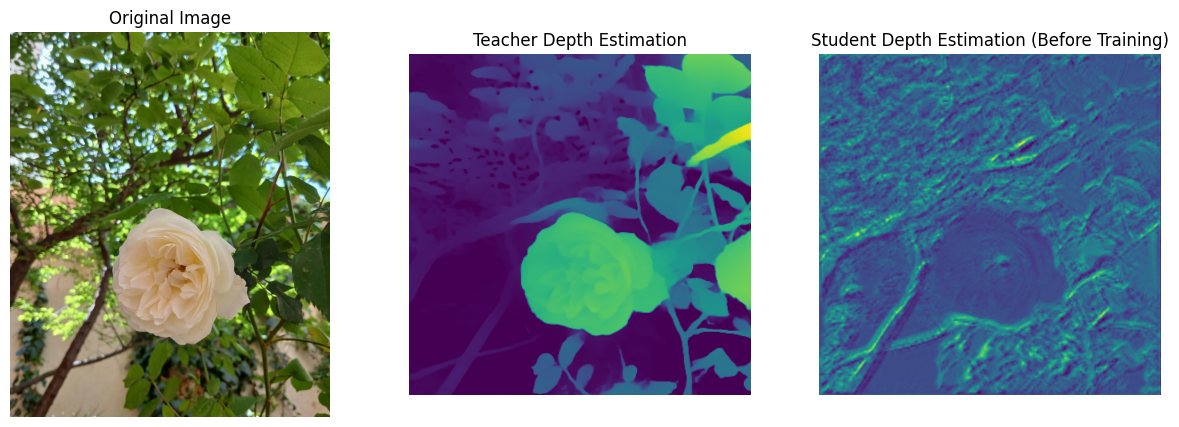

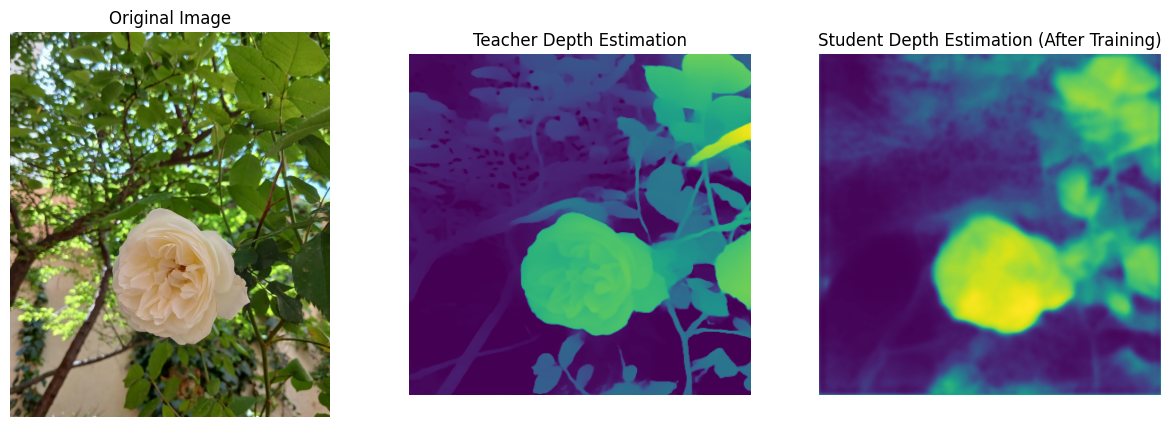

In [25]:
# Load image
image_path = "/content/drive/MyDrive/images/image1.JPG"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = eval_transform(Image.fromarray(image)).unsqueeze(0).to(device)

# Set models to evaluation mode
teacher_model.eval() # Use the DepthModel instance
student_model.eval() # Use the DepthModel instance


with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    start_time = time.time()
    student_output_after, Sfeat = student_model(input_tensor)
    end_time = time.time()
    inference_time_ms = (end_time - start_time) * 1000
    print(f"✅ Student model inference time: {inference_time_ms:.2f} ms")

    student_output_after_training = student_output_after.squeeze().cpu().numpy()

    # Teacher prediction using the DepthModel instance
    teacher_depth, Tfeat = teacher_model(input_tensor)
    print(teacher_depth.shape)
    teacher_depth = teacher_depth.squeeze().cpu().numpy()

# loss = distillation_criterion(student_output_after_training, teacher_depth)
# print(loss.item())
#Befor training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth_before_training_train_image, cmap="viridis")
plt.title("Student Depth Estimation (Before Training)")
plt.axis("off")

plt.show()

#After training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_output_after_training, cmap="viridis")
plt.title("Student Depth Estimation (After Training)")
plt.axis("off")

plt.show()



### On Testing

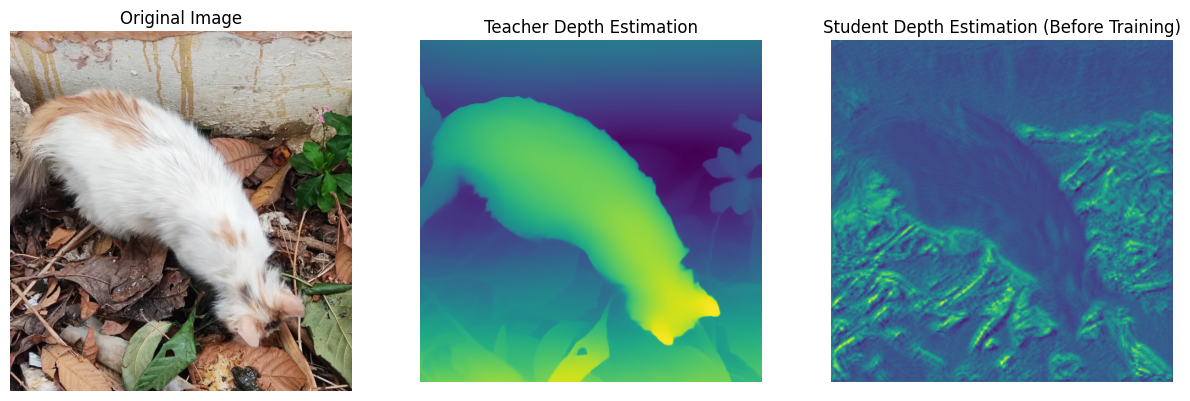

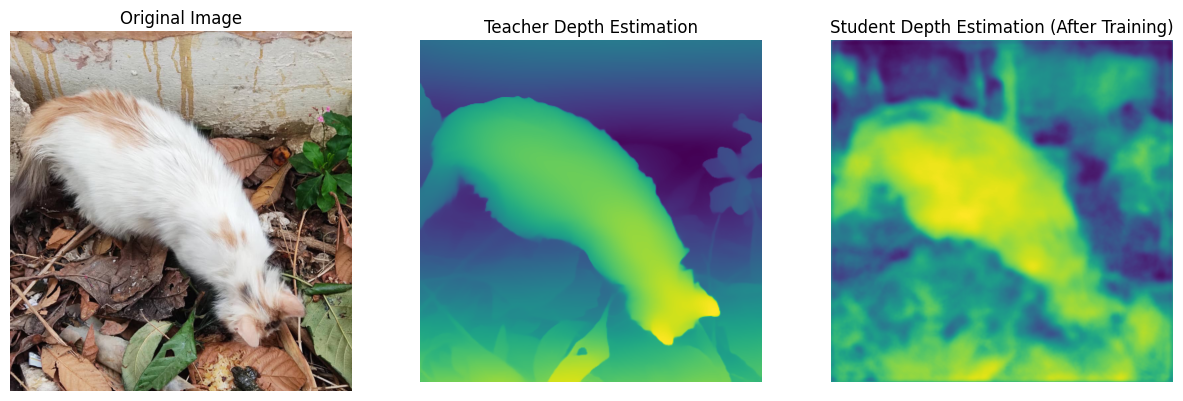

In [26]:
# Load image
image_path = "/content/test.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = eval_transform(Image.fromarray(image)).unsqueeze(0).to(device)

# Set models to evaluation mode
teacher_model.eval() # Use the DepthModel instance
student_model.eval() # Use the DepthModel instance

loss = 0;
with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    student_output_after, Sfeat = student_model(input_tensor)
    student_output_after_training = student_output_after.squeeze().cpu().numpy()

    # Teacher prediction using the DepthModel instance
    teacher_depth, Tfeat = teacher_model(input_tensor)
    # loss = distillation_criterion(student_output_after, teacher_depth)
    teacher_depth = teacher_depth.squeeze().cpu().numpy()

# print(loss.item())
#Befor training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth_before_training, cmap="viridis")
plt.title("Student Depth Estimation (Before Training)")
plt.axis("off")

plt.show()

#After training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_output_after_training, cmap="viridis")
plt.title("Student Depth Estimation (After Training)")
plt.axis("off")

plt.show()

### Export To onnx

In [ ]:
%pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 107.3 MB/s eta 0:00:00


In [34]:
import onnx
dummy_input = torch.randn(1, 3, 384, 384).to(device)
onnx_model_path = '/content/drive/MyDrive/LastWrapped.onnx'
print(f"Exporting model to ONNX format at {onnx_model_path}...")


student_model.eval()

torch.onnx.export(
    student_model,                # The model to export
    dummy_input,                 # A sample input tensor
    onnx_model_path,             # Where to save the model
    export_params=True,          # Store the trained parameter weights inside the model file
    opset_version=14,            # The ONNX version to use (11, 12 are good choices)
    do_constant_folding=True,    # A performance optimization
    input_names=['input'],       # A name for the model's input
    output_names=['output_depth'], # A name for the model's output
    dynamic_axes={               # Allows for variable input image sizes
        'input': {0: 'batch_size', 2: 'height', 3: 'width'},
        'output_depth': {0: 'batch_size', 2: 'height', 3: 'width'}
    }
)

print("\nONNX export complete!")
print(f"Model saved to: {onnx_model_path}")
print("\nNext step: You can now use a tool like 'onnx-tf' to convert this .onnx file to a TensorFlow SavedModel, and then to TFLite.")

Exporting model to ONNX format at /content/drive/MyDrive/LastWrapped.onnx...


/usr/local/lib/python3.11/dist-packages/timm/models/mobilevit.py:239: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  new_h, new_w = math.ceil(H / patch_h) * patch_h, math.ceil(W / patch_w) * patch_w
/usr/local/lib/python3.11/dist-packages/timm/models/mobilevit.py:243: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if new_h != H or new_w != W:



ONNX export complete!
Model saved to: /content/drive/MyDrive/LastWrapped.onnx

Next step: You can now use a tool like 'onnx-tf' to convert this .onnx file to a TensorFlow SavedModel, and then to TFLite.
